In [1]:
from __future__ import print_function
# from IPython.display import Math, HTML
import keras
import struct
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
from keras.models import Model
from keras.optimizers import RMSprop, Adam, SGD

2023-12-22 18:01:51.478320: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Dataset Exploration

Shape of MNIST train images: (10000, 28, 28)
Shape of MNIST test images: (4000, 28, 28)


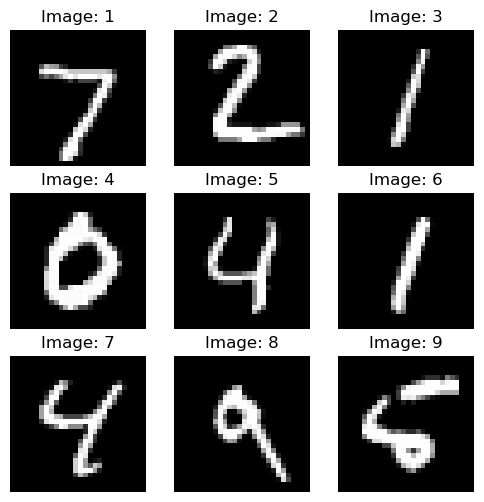

In [2]:
# make a function to get the MNIST data from a file and return it as a numpy array
def read_mnist_images(file_path):
    with open(file_path, 'rb') as f:
        # Read magic number, number of images, rows, and columns
        magic_number, num_images, rows, cols = struct.unpack('>IIII', f.read(16))

        # Read image data
        image_size = rows * cols
        images = np.frombuffer(f.read(image_size * num_images), dtype=np.uint8)
        images = images.reshape(num_images, rows, cols)

    return images

# Provide the path to your MNIST dataset file
file_path = './datasets/10k_images.dat'
file_path2 = './datasets/4kfrom60k.dat'

# Read MNIST images from the fileread_mnist_images(file_path)
train_data = read_mnist_images(file_path)
test_data = read_mnist_images(file_path2)
# Print the shape of the data
print(f'Shape of MNIST train images: {train_data.shape}')
print(f'Shape of MNIST test images: {test_data.shape}')

# Display the first 9 images in training data
fig, ax = plt.subplots(3, 3, figsize=(6, 6))
for i, axis in enumerate(ax.flat):
    axis.imshow(train_data[i], cmap='gray')
    axis.axis('off')
    axis.set(title = f'Image: {i+1}')
plt.show()



# Data Pre-processing

In [3]:
train_data = train_data.reshape(-1, 28, 28, 1)
test_data = test_data.reshape(-1, 28, 28, 1)
# check the shape of the data
print(f'Shape of MNIST images: {train_data.shape}')

# convert the data type to float32
train_data = train_data.astype('float32')
test_data = test_data.astype('float32')

# check the type of the data
print(f'Type of MNIST train images: {train_data.dtype}')
print(f'Type of MNIST test images: {test_data.dtype}')


# normalize the data
train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)

# check the range of the data
print(f'Range of MNIST test images: {train_data.min()} to {train_data.max()}')
print(f'Range of MNIST train images: {test_data.min()} to {test_data.max()}')

# parition the data into training and validation sets
from sklearn.model_selection import train_test_split
train_X, valid_X, train_ground, valid_ground = train_test_split(train_data,
                                                                train_data,
                                                                test_size=0.2)

# print the shape of training data and validation data
print(f'Shape of training data: {train_X.shape}')
print(f'Shape of validation data: {valid_X.shape}')

print(f'Shape of training labels: {train_ground.shape}')
print(f'Shape of validation labels: {valid_ground.shape}')

Shape of MNIST images: (10000, 28, 28, 1)
Type of MNIST train images: float32
Type of MNIST test images: float32
Range of MNIST test images: 0.0 to 1.0
Range of MNIST train images: 0.0 to 1.0
Shape of training data: (8000, 28, 28, 1)
Shape of validation data: (2000, 28, 28, 1)
Shape of training labels: (8000, 28, 28, 1)
Shape of validation labels: (2000, 28, 28, 1)


# The Convolutional Autoencoder

In [4]:
batch_size = 128
epochs = 10
inChannel = 1
x, y = 28, 28
input_img = Input(shape=(x, y, inChannel))

In [5]:
def encoder(input_img):
    # Encoder layers
    conv1 = Conv2D(32, (7, 7), activation='relu', padding='same')(input_img)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, (7, 7), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, (7, 7), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)

    # Latent dimension (change the size as needed)
    latent_dim = 10
    bottleneck = Conv2D(latent_dim, (7, 7), activation='relu', padding='same')(conv3)
    bottleneck = BatchNormalization()(bottleneck)

    return bottleneck

def decoder(bottleneck):
    # Decoder layers
    conv4 = Conv2D(128, (7, 7), activation='relu', padding='same')(bottleneck)
    conv4 = BatchNormalization()(conv4)
    up1 = UpSampling2D((2, 2))(conv4)
    conv5 = Conv2D(64, (7, 7), activation='relu', padding='same')(up1)
    conv5 = BatchNormalization()(conv5)
    up2 = UpSampling2D((2, 2))(conv5)
    decoded = Conv2D(1, (7, 7), activation='sigmoid', padding='same')(up2)

    return decoded

# Input layer
input_img = Input(shape=(28, 28, 1))

# Create the encoder and decoder models
encoder_model = Model(input_img, encoder(input_img))
autoencoder = Model(input_img, decoder(encoder(input_img)))

# Compile the autoencoder model
encoder_model.compile(loss='mean_squared_error', optimizer=RMSprop(0.01))
autoencoder.compile(loss='mean_squared_error', optimizer=RMSprop(0.01))

# Print model summaries
encoder_model.summary()
autoencoder.summary()

2023-12-22 18:01:53.897757: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        1600      
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        100416    
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       256   

# Train the model

In [6]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size, epochs=epochs, verbose=1,validation_data=(valid_X, valid_ground))

Epoch 1/10
63/63 [==============================] - 47s 723ms/step - loss: 0.1334 - val_loss: 0.1770
Epoch 2/10
63/63 [==============================] - 49s 770ms/step - loss: 0.0932 - val_loss: 0.1694
Epoch 3/10
63/63 [==============================] - 47s 745ms/step - loss: 0.0593 - val_loss: 0.1998
Epoch 4/10
63/63 [==============================] - 49s 786ms/step - loss: 0.0381 - val_loss: 0.1183
Epoch 5/10
63/63 [==============================] - 48s 765ms/step - loss: 0.0284 - val_loss: 0.0599
Epoch 6/10
63/63 [==============================] - 48s 769ms/step - loss: 0.0223 - val_loss: 0.0461
Epoch 7/10
63/63 [==============================] - 49s 785ms/step - loss: 0.0186 - val_loss: 0.0477
Epoch 8/10
63/63 [==============================] - 49s 772ms/step - loss: 0.0150 - val_loss: 0.0397
Epoch 9/10
63/63 [==============================] - 51s 811ms/step - loss: 0.0130 - val_loss: 0.0311
Epoch 10/10
63/63 [==============================] - 46s 726ms/step - loss: 0.0113 - val_lo

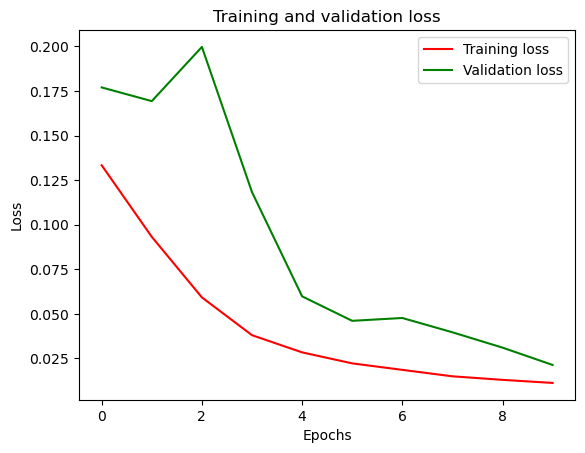

In [7]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, '-r', label='Training loss')
plt.plot(epochs, val_loss, '-g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Test the Model

125/125 [==============================] - 15s 122ms/step


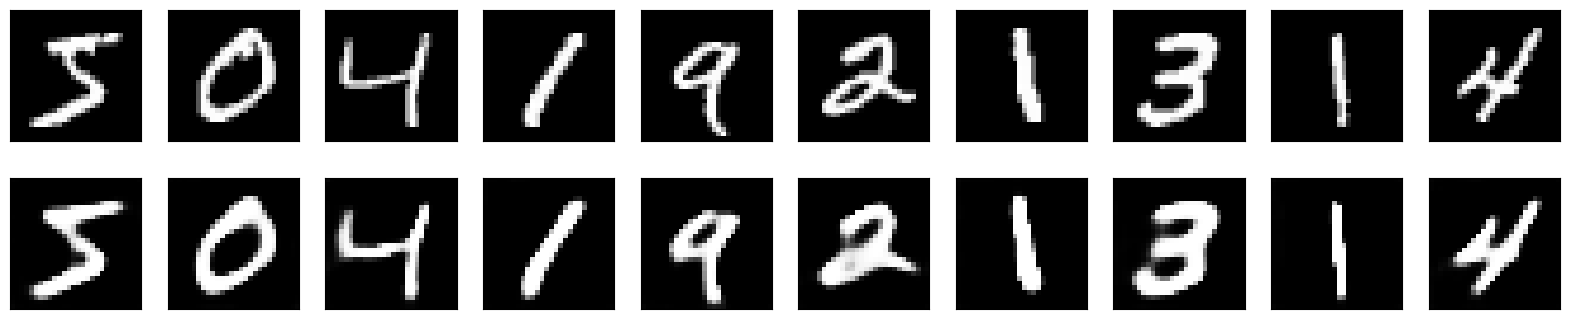

125/125 [==============================] - 8s 60ms/step


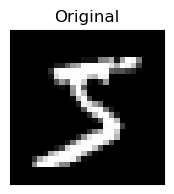

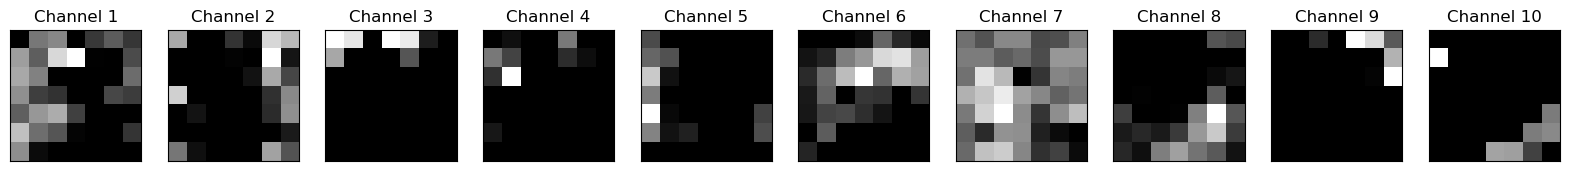

In [13]:
# Predict the autoencoder output from test images
pred = autoencoder.predict(test_data)

# Plot the original test images and their reconstructions
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
for images, row in zip([test_data, pred], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.show()

# Predict the encoder output from test images
encoded_data = encoder_model.predict(test_data)

# # Display the encoded representations
# fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(20, 20))
# for i in range(10):  # Iterate over each encoded dimension
#     for j in range(10):  # Iterate over 10 images
#         # Select the i-th channel from the j-th image
#         channel_img = encoded_data[j, :, :, i]

#         # Plot the 7x7 image
#         axes[i, j].imshow(channel_img, cmap='gray')
#         axes[i, j].get_xaxis().set_visible(False)
#         axes[i, j].get_yaxis().set_visible(False)
# plt.show()

# Display the original image in a separate plot
fig_original, ax_original = plt.subplots(figsize=(2, 2))
ax_original.imshow(test_data[0, :, :, 0], cmap='gray')
ax_original.set_title('Original')
ax_original.get_xaxis().set_visible(False)
ax_original.get_yaxis().set_visible(False)
plt.show()

# Display the 10 separate 7x7 images for the first encoded image
fig_encoded, axes_encoded = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    # Select the i-th channel from the first encoded image
    channel_img = encoded_data[0, :, :, i]

    # Plot the 7x7 image
    axes_encoded[i].imshow(channel_img, cmap='gray')
    axes_encoded[i].set_title(f'Channel {i+1}')
    axes_encoded[i].get_xaxis().set_visible(False)
    axes_encoded[i].get_yaxis().set_visible(False)

plt.show()

# save the model
autoencoder.save('autoencoder.h5')
encoder_model.save('encoder.h5')